# Modeling

Now that we have our data cleaned the way we want it, we're ready to start testing it & loading it into a linear regression model. As always, our first step is to load the libaries necessary.

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [53]:
pd.set_option('display.max_columns', None)

In [5]:
USA_2019 = pd.read_csv('2019_US_Accident_Data.csv')
USA_2019.drop(columns=['Unnamed: 0'], inplace=True) # dropping the old index column from the original dataset
USA_2019.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Date,Time_Lapse
0,A-512238,MapQuest,201.0,2,2019-12-25 18:05:59,2019-12-25 19:11:09,42.967209,-83.671837,0.000000,Accident on Saginaw St at Judd Rd.,...,False,False,False,False,1,1,0,0,2019,65.166667
1,A-512240,MapQuest,201.0,2,2019-12-25 23:14:22,2019-12-26 01:04:38,43.028240,-83.719643,0.000000,Accident on Milbourne Ave at Clement St.,...,False,False,False,False,1,1,1,1,2019,110.266667
2,A-512241,MapQuest,201.0,2,2019-12-25 00:20:27,2019-12-25 01:32:05,43.093609,-73.528770,0.000000,Lane blocked due to accident on NY-29 both way...,...,False,False,False,False,1,1,1,1,2019,71.633333
3,A-512242,MapQuest,201.0,3,2019-12-25 16:21:20,2019-12-25 17:05:40,43.327518,-73.684631,1.710000,Accident on exit ramp from I-87 Southbound at ...,...,False,False,False,False,0,0,0,0,2019,44.333333
4,A-512243,MapQuest,201.0,3,2019-12-25 07:13:20,2019-12-25 09:37:22,42.393494,-73.826744,17.200001,Accident on I-87 Northbound between Exit 21 CR...,...,False,False,False,False,1,0,0,0,2019,144.033333


In [141]:
USA_2019.shape

(201272, 49)

## Hypothesis Testing

### Hypothesis Test #1

The first thing we want to investigate is whether or not there is a difference in the delay time, our calculated 'Time_Lapse' column, and the severity of an accident.

In this case, our Null Hypothesis is:

There is no difference between the severity of an accident and the amount of delay it causes.

Our Alternative Hypothesis is:

There is a difference between the severity of an accident and the amount of delay it causes.

To do this, we will use an ANOVA test to first note if there is any difference. If there is such a difference, we then run a MultiComparison test the mean delay time for each individual severity level against the others.

To note, the scale is ascending with 1 as the least severe and 4 is the most severe.

Below is a boxplot of the distribution be severity level.

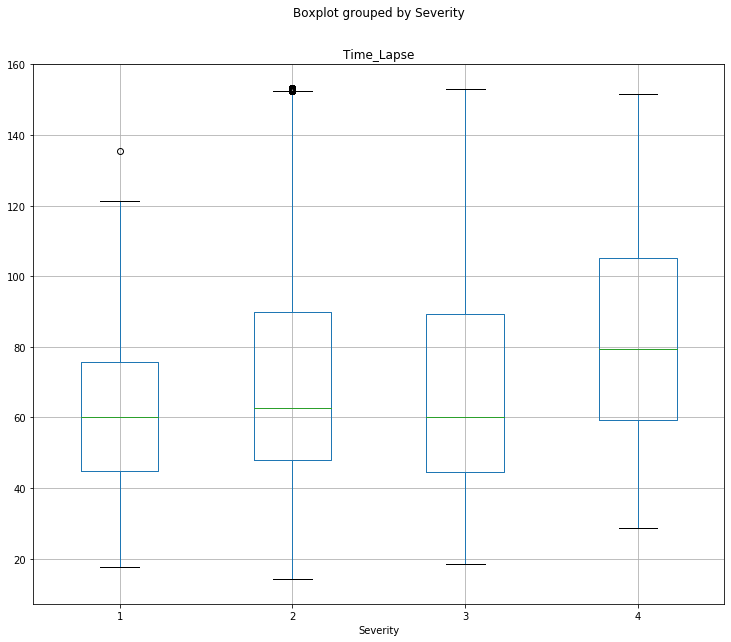

In [150]:
USA_2019.boxplot('Time_Lapse', by='Severity', figsize=(12,10))
plt.savefig('Severity_Comparison.png')
plt.show()

In [14]:
# Mean comparison by severity level

USA_2019.groupby('Severity')[['Time_Lapse']].mean()

,Time_Lapse
Severity,
1,60.567147
2,70.916908
3,67.213957
4,83.971102


In [15]:
lr_model = ols(formula= 'Time_Lapse~Severity', data=USA_2019).fit()

In [31]:
anova_table = sm.stats.anova_lm(lr_model, type=2)
print(anova_table)

                df        sum_sq        mean_sq           F        PR(>F)
Severity       1.0  1.235131e+05  123513.083687  150.829002  1.175414e-34
Residual  201270.0  1.648190e+08     818.894790         NaN           NaN


Our p-value here - PR(>F) - is really small in this instance, meaning we would reject the null hypothesis that there is no difference between average delay time and the severity of the accident. We still don't know which group is the most severe. From here we want to see the comparisons by each level. To do so, we use a MultiComparison test.

In [34]:
mc = MultiComparison(USA_2019['Time_Lapse'], USA_2019['Severity'])
mc_results = mc.tukeyhsd()
mc_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,10.3498,0.0013,3.1404,17.5592,True
1,3,6.6468,0.0852,-0.5907,13.8843,False
1,4,23.404,0.001,13.6308,33.1771,True
2,3,-3.703,0.001,-4.3834,-3.0225,True
2,4,13.0542,0.001,6.4514,19.657,True
3,4,16.7571,0.001,10.1237,23.3906,True


As we can see, we reject our null hypothesis for almost every point of comparison. Interestingly in our data, we fail to reject the null hypothesis when comparing severity level 1 delay times and level 3 delay times, meaning there is no difference between the delay times caused by these two types of accidents. From this, we'll definitely want to include severity as a predictor of our delay time of an accident.

### Hypothesis Test #2

We have a ton of data around accidents that happen during the day or night. There are 4 columns dedicated to different kinds of day or night - Sunrise_Sunset, Civil_Twilight, Nautical_Twilight and Astronomical_Twilight. We want to see if there's a difference between delay times that happen during the day versus accidents that happen at night. For this hypothesis test we're focusing on the Sunrise_Sunset column.

In this test, our Null Hypothesis is:

There is no difference in the average delay time for an accident that happens during the day versus one that happens at night.

And the Alternative Hypothesis is:

There is a difference in the average delay time for an accident that happens during the day versus one that happens at night.

First, we need to separate our data.

In [20]:
day_night = USA_2019[['Time_Lapse', 'Sunrise_Sunset']]
day_night.head()

day = day_night[day_night['Sunrise_Sunset'] == 0]
night = day_night[day_night['Sunrise_Sunset'] == 1]

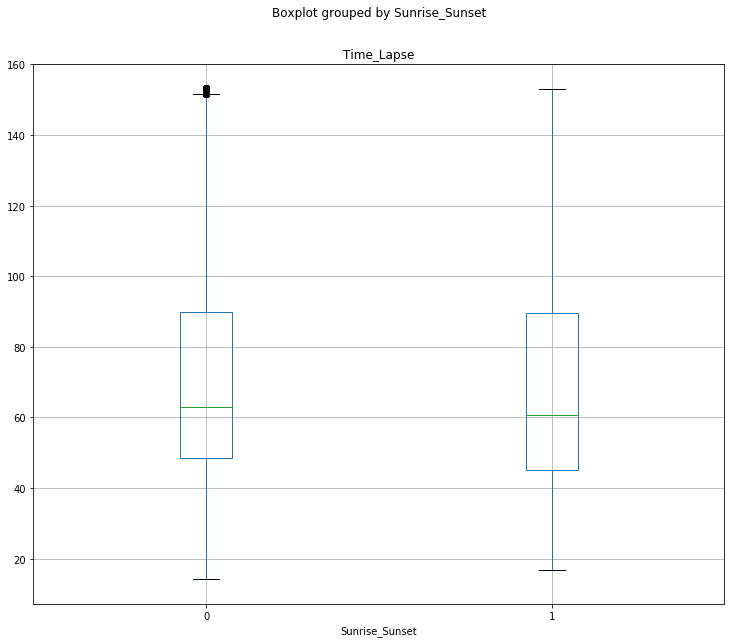

In [151]:
USA_2019.boxplot('Time_Lapse', by='Sunrise_Sunset', figsize=(12,10))
plt.savefig('DayNight_Comparison.png')
plt.show()

In [23]:
# Check the size of the data

day.shape, night.shape

((158981, 2), (42291, 2))

Before running our two sided t-test, we want to make sure we're working with equal variance.

In [26]:
day_mean = day['Time_Lapse'].mean()
day_std = day['Time_Lapse'].std()

day_mean, day_std

(71.13118789876327, 28.354878304711487)

In [28]:
night_mean = night['Time_Lapse'].mean()
night_std = night['Time_Lapse'].std()

night_mean, night_std

(69.03506183348699, 29.56927104679561)

In [29]:
stats.ttest_ind(day['Time_Lapse'], night['Time_Lapse'])

Ttest_indResult(statistic=13.388715060257768, pvalue=7.328496745359894e-41)

Once again, our p-value is smaller than our alpha level 0.05. We in this case, we can reject the null hypothesis that there is no difference between accidents that happen during the day and accidents that happen at night. We'll want to include this as we build our prediction model.

## Building our Linear Regression Model

Now that we've run some hypothesis tests on our assumed features, we can start to build our model. Before we do anything, we'll want to split our data set into a training set and a test set. We'll first run models using different features on our training data set. Once we feel we have a good model, we will pass through our test features to predict our target variable. To assess the accuracy of this model, we will then compare our predictions versus our actuals in our test set.

In [44]:
corr = USA_2019.corr()
corr['Time_Lapse']

TMC                      0.044265
Severity                -0.027365
Start_Lat               -0.033539
Start_Lng                0.012650
Distance(mi)             0.008513
Number                   0.014477
Side                    -0.001952
State                    0.011800
Temperature(F)           0.087847
Wind_Chill(F)            0.093251
Humidity(%)             -0.037194
Pressure(in)            -0.005603
Visibility(mi)           0.051426
Wind_Direction           0.006586
Wind_Speed(mph)         -0.010622
Precipitation(in)       -0.001838
Weather_Condition       -0.013889
Amenity                 -0.001167
Bump                    -0.003080
Crossing                -0.010357
Give_Way                 0.001725
Junction                -0.006061
No_Exit                 -0.009942
Railway                  0.007168
Roundabout              -0.002564
Station                  0.000857
Stop                    -0.005646
Traffic_Calming         -0.003728
Traffic_Signal           0.009023
Turning_Loop  

In [35]:
# Setting 'Time_Lapse' as our target variable.

target = USA_2019['Time_Lapse']

In [46]:
# Loading in all of our columns as our features for our first model.

features = USA_2019[['Severity','Start_Lat','Start_Lng','Side', 'State', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 
                     'Visibility(mi)','Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 
                     'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
                     'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 
                     'Nautical_Twilight', 'Astronomical_Twilight']]

In [47]:
# Split data.

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=34,test_size=0.2)

In [48]:
model_1 = sm.OLS(y_train,X_train.astype(float)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Time_Lapse   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          3.419e+04
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                        0.00
Time:                        16:22:31   Log-Likelihood:                     -7.6793e+05
No. Observations:              161017   AIC:                                  1.536e+06
Df Residuals:                  160988   BIC:                                  1.536e+06
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Severity                 -1.4021      0.286     -4.908      0.000      -1.962      -0.842
Start_Lat                 0.1953      0.016     12.184      0.000       0.164       0.227
Start_Lng                -0.0325      0.005     -6.286      0.000      -0.043      -0.022
Side                      0.0380      0.142      0.267      0.789      -0.241       0.317
State                     0.0318      0.005      5.819      0.000       0.021       0.043
Temperature(F)            0.1559      0.005     32.180      0.000       0.146       0.165
Humidity(%)               0.0168      0.004      4.144      0.000       0.009       0.025
Pressure(in)              1.6127      0.036     44.435      0.000       1.542       1.684
Visibility(mi)            0.5388      0.031     17.308      0.000       0.478       0.600
Wind_Direction           -0.0019      0.011     -0.169      0.866      -0.024       0.021
Wind_Speed(mph)          -0.0422      0.015     -2.765      0.006      -0.072      -0.012
Precipitation(in)         2.3361      0.972      2.404      0.016       0.432       4.241
Weather_Condition        -0.0216      0.004     -5.548      0.000      -0.029      -0.014
Amenity                  -0.3842      0.461     -0.833      0.405      -1.288       0.520
Bump                     -0.3815      4.925     -0.077      0.938     -10.034       9.271
Crossing                 -1.4621      0.245     -5.962      0.000      -1.943      -0.981
Give_Way                  1.4473      1.591      0.909      0.363      -1.672       4.567
Junction                 -1.9026      1.278     -1.488      0.137      -4.408       0.603
No_Exit                  -4.5399      1.523     -2.981      0.003      -7.525      -1.555
Railway                   2.2798      0.650      3.507      0.000       1.006       3.554
Roundabout               -0.3189      7.020     -0.045      0.964     -14.078      13.440
Station                  -0.2119      0.398     -0.532      0.594      -0.992       0.568
Stop                     -0.4394      0.410     -1.072      0.284      -1.243       0.364
Traffic_Calming          -1.4784      3.850     -0.384      0.701      -9.024       6.067
Traffic_Signal            0.9745      0.179      5.455      0.000       0.624       1.325
Sunrise_Sunset            1.2192      0.335      3.637      0.000       0.562       1.876
Civil_Twilight            0.3589      0.460      0.780      0.436      -0.543       1.261
Nautical_Twilight        -1.5454      0.505     -3.063      0.002      -2.534      -0.557
Astronomical_Twilight    -3.3214      0.453     -7.325      0.000      -4.210      -2.433
==============================================================================
Omnibus:                 

In [50]:
# Check how many features we're including by using .shape. In our first model there are 29!

features.shape

(201272, 29)

Now we want to check how well our model predicts for our target varaible. To do so, we run .predict on our independent train dataset and our test. We then compare the Mean Absolute Error, Mean Squared Error and the Square Root of the Mean Score Error. We know if we overfit if the train error comes down, but the test error increases.

In [120]:
ypred_train = model_1.predict(X_train)
ypred_test = model_1.predict(X_test)

In [61]:
residual = ypred - y_test

In [124]:
print('Train - Mean Absolute Error:' + str(metrics.mean_absolute_error(y_train, ypred_train)))
print('Train - Mean Squared Error:' + str(metrics.mean_squared_error(y_train, ypred_train)))
print('Train - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_train, ypred_train))))

print("")

print('Test - Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, ypred)))
print('Test - Mean Squared Error:' + str(metrics.mean_squared_error(y_test, ypred)))
print('Test - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, ypred))))

Train - Mean Absolute Error:22.716285660643944
Train - Mean Squared Error:812.9474531872152
Train - Mean Squared Error:28.512233395285175

Test - Mean Absolute Error:22.71514145374325
Test - Mean Squared Error:814.5548364543636
Test - Mean Squared Error:28.540407082842453


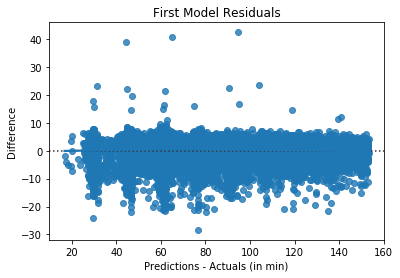

In [86]:
sns.residplot(y_test,ypred,lowess=True)
plt.title('First Model Residuals')
plt.xlabel('Predictions - Actuals (in min)')
plt.ylabel('Difference')
plt.show()

Our first pass gives us an R-Squared value of .861 - a great score, but when we look at our warnings at the bottom, we're warned about Multicollinearity, meaning that some of our independent variables can explain changes in other independent variables. In our next model, we want to adjust for that. Using our correlation chart, we can decide which features we want to drop to avoid the multicollinearity problem. Our threshold for multicollinearity is 0.50.

In [57]:
abs(features.corr()) > 0.50

,Severity,Start_Lat,Start_Lng,Side,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
Severity,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Start_Lat,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Start_Lng,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Side,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
State,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Temperature(F),False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Humidity(%),False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Pressure(in),False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Visibility(mi),False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Wind_Direction,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


We want to drop any columns that come back as true when compared to a different column. Based on this chart, for our next model, we will drop:

    Civil_Twilight
    Nautical_Twilight
    Astronomical_Twilight

Now to reset our features. Our target is still the same, but we'll want to remove the features listed above and re-run our model.

In [59]:
features_2 = USA_2019[['Severity','Start_Lat','Start_Lng','Side', 'State', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 
                     'Visibility(mi)','Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 
                     'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 
                     'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']]

In [76]:
X2_train, X2_test, y2_train, y2_test = train_test_split(features_2, target, random_state=34,test_size=0.2)

In [77]:
model_2 = sm.OLS(y2_train, X2_train.astype(float)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Time_Lapse   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          3.809e+04
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:08:30   Log-Likelihood:                     -7.6803e+05
No. Observations:              161017   AIC:                                  1.536e+06
Df Residuals:                  160991   BIC:                                  1.536e+06
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Severity             -1.4669      0.286     -5.133      0.000      -2.027      -0.907
Start_Lat             0.2004      0.016     12.497      0.000       0.169       0.232
Start_Lng            -0.0295      0.005     -5.709      0.000      -0.040      -0.019
Side                  0.0459      0.142      0.323      0.747      -0.233       0.325
State                 0.0319      0.005      5.831      0.000       0.021       0.043
Temperature(F)        0.1573      0.005     32.455      0.000       0.148       0.167
Humidity(%)           0.0167      0.004      4.136      0.000       0.009       0.025
Pressure(in)          1.6169      0.036     44.526      0.000       1.546       1.688
Visibility(mi)        0.5340      0.031     17.146      0.000       0.473       0.595
Wind_Direction       -0.0018      0.011     -0.155      0.877      -0.024       0.021
Wind_Speed(mph)      -0.0398      0.015     -2.603      0.009      -0.070      -0.010
Precipitation(in)     2.4089      0.972      2.478      0.013       0.503       4.314
Weather_Condition    -0.0213      0.004     -5.454      0.000      -0.029      -0.014
Amenity              -0.4561      0.461     -0.988      0.323      -1.360       0.448
Bump                 -0.2261      4.928     -0.046      0.963      -9.884       9.432
Crossing             -1.4625      0.245     -5.960      0.000      -1.943      -0.982
Give_Way              1.4199      1.592      0.892      0.373      -1.701       4.541
Junction             -2.0148      1.279     -1.575      0.115      -4.522       0.492
No_Exit              -4.5395      1.524     -2.979      0.003      -7.526      -1.553
Railway               2.2707      0.650      3.491      0.000       0.996       3.546
Roundabout           -0.6663      7.024     -0.095      0.924     -14.433      13.101
Station              -0.2161      0.398     -0.543      0.587      -0.997       0.564
Stop                 -0.4090      0.410     -0.997      0.319      -1.213       0.395
Traffic_Calming      -1.7556      3.852     -0.456      0.649      -9.306       5.795
Traffic_Signal        1.0210      0.179      5.713      0.000       0.671       1.371
Sunrise_Sunset       -0.5874      0.186     -3.155      0.002      -0.952      -0.222
==============================================================================
Omnibus:                     9307.262   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11035.974
Skew:                           0.641   Prob(JB):                         0.00
Kurtosis:                       3.000   Cond. No.                     1.42e+04
==============================================================================

Warnings:
[1] S

In [91]:
# We're still using a lot of features - now we're down to 26 in total.

X2_train.shape

(161017, 26)

In [122]:
y2_pred_train = model_2.predict(X2_train)
y2_pred_test = model_2.predict(X2_test)

In [79]:
residual = y2_pred - y2_test

In [133]:
print('Train - Mean Absolute Error:' + str(metrics.mean_absolute_error(y2_train, y2_pred_train)))
print('Train - Mean Squared Error:' + str(metrics.mean_squared_error(y2_train, y2_pred_train)))
print('Train - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y2_train, y2_pred_train))))

print("")

print('Test - Mean Absolute Error:' + str(metrics.mean_absolute_error(y2_test, y2_pred_test)))
print('Test - Mean Squared Error:' + str(metrics.mean_squared_error(y2_test, y2_pred_test)))
print('Test - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_test))))

Train - Mean Absolute Error:22.735824464177416
Train - Mean Squared Error:813.9240136681619
Train - SqRt Mean Squared Error:28.529353544519054

Test - Mean Absolute Error:22.73172793091911
Test - Mean Squared Error:815.777756499039
Test - SqRt Mean Squared Error:28.561823409912733


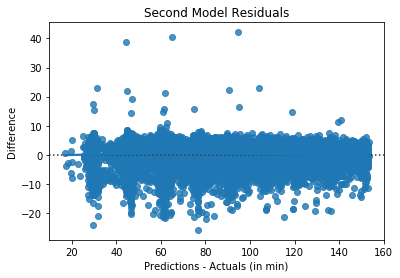

In [87]:
sns.residplot(y2_test,y2_pred,lowess=True)
plt.title('Second Model Residuals')
plt.xlabel('Predictions - Actuals (in min)')
plt.ylabel('Difference')
plt.show()

Great! We handled our features with Multicollinearity, but we do still have some unnecessary features in our model. When looking at our OLS Summary and checking the p-value of some of the coefficients, we have some that are statistically insignificant. These values are greater than our alpha 0.05. For our next model, we are going to further reduce our features by removing the following:

       Side
       Wind_Direction
       Precipitation(in)
       Amenity
       Bump
       Give_Way
       Junction
       Roundabout

In [92]:
features_3 = USA_2019[['Severity','Start_Lat','Start_Lng', 'State', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 
                     'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Crossing', 'No_Exit', 'Railway', 
                     'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']]

In [93]:
X3_train, X3_test, y3_train, y3_test = train_test_split(features_3, target, random_state=34,test_size=0.2)

In [94]:
model_3 = sm.OLS(y3_train, X3_train.astype(float)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Time_Lapse   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          5.501e+04
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:20:54   Log-Likelihood:                     -7.6804e+05
No. Observations:              161017   AIC:                                  1.536e+06
Df Residuals:                  160999   BIC:                                  1.536e+06
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Severity             -1.4774      0.285     -5.181      0.000      -2.036      -0.919
Start_Lat             0.1990      0.016     12.551      0.000       0.168       0.230
Start_Lng            -0.0294      0.005     -5.682      0.000      -0.040      -0.019
State                 0.0319      0.005      5.835      0.000       0.021       0.043
Temperature(F)        0.1575      0.005     32.699      0.000       0.148       0.167
Humidity(%)           0.0172      0.004      4.269      0.000       0.009       0.025
Pressure(in)          1.6204      0.036     44.747      0.000       1.549       1.691
Visibility(mi)        0.5268      0.031     17.002      0.000       0.466       0.587
Wind_Speed(mph)      -0.0395      0.014     -2.772      0.006      -0.067      -0.012
Weather_Condition    -0.0210      0.004     -5.385      0.000      -0.029      -0.013
Crossing             -1.4603      0.245     -5.963      0.000      -1.940      -0.980
No_Exit              -4.5417      1.521     -2.987      0.003      -7.522      -1.561
Railway               2.2516      0.650      3.462      0.001       0.977       3.526
Station              -0.2886      0.392     -0.737      0.461      -1.056       0.479
Stop                 -0.4070      0.410     -0.992      0.321      -1.211       0.397
Traffic_Calming      -1.8719      2.409     -0.777      0.437      -6.593       2.849
Traffic_Signal        1.0163      0.178      5.697      0.000       0.667       1.366
Sunrise_Sunset       -0.5871      0.186     -3.154      0.002      -0.952      -0.222
==============================================================================
Omnibus:                     9307.041   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11035.668
Skew:                           0.641   Prob(JB):                         0.00
Kurtosis:                       3.000   Cond. No.                     4.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
# Cutting back on our features even more. With this model, we're using 18.

X3_train.shape

(161017, 18)

In [126]:
y3_pred_train = model_3.predict(X3_train)
y3_pred_test = model_3.predict(X3_test)

In [98]:
residual = y3_pred - y3_test

In [134]:
print('Train - Mean Absolute Error:' + str(metrics.mean_absolute_error(y3_train, y3_pred_train)))
print('Train - Mean Squared Error:' + str(metrics.mean_squared_error(y3_train, y3_pred_train)))
print('Train - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y3_train, y3_pred_train))))

print("")

print('Test - Mean Absolute Error:' + str(metrics.mean_absolute_error(y3_test, y3_pred_test)))
print('Test - Mean Squared Error:' + str(metrics.mean_squared_error(y3_test, y3_pred_test)))
print('Test - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y3_test, y3_pred_test))))

Train - Mean Absolute Error:22.73629328716602
Train - Mean Squared Error:813.9779878033895
Train - SqRt Mean Squared Error:28.530299469220253

Test - Mean Absolute Error:22.73231102397341
Test - Mean Squared Error:815.851622569114
Test - SqRt Mean Squared Error:28.563116471581214


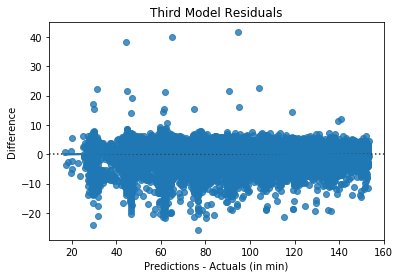

In [100]:
sns.residplot(y3_test,y3_pred,lowess=True)
plt.title('Third Model Residuals')
plt.xlabel('Predictions - Actuals (in min)')
plt.ylabel('Difference')
plt.show()

Our third model is still a good predictor for our delay time. Now that we've eliminated columns that are statistically insignificant, we're seeing we have two more that aren't adding any value to what we're trying to calculate. This time we're going to drop Station & Stop from our features and see if it helps our model.

In [101]:
features_4 = USA_2019[['Severity','Start_Lat','Start_Lng', 'State', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 
                     'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Crossing', 'No_Exit', 'Railway', 
                     'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']]

In [102]:
X4_train, X4_test, y4_train, y4_test = train_test_split(features_4, target, random_state=34,test_size=0.2)

In [103]:
model_4 = sm.OLS(y4_train, X4_train.astype(float)).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Time_Lapse   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          6.189e+04
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:26:32   Log-Likelihood:                     -7.6804e+05
No. Observations:              161017   AIC:                                  1.536e+06
Df Residuals:                  161001   BIC:                                  1.536e+06
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Severity             -1.4566      0.285     -5.117      0.000      -2.015      -0.899
Start_Lat             0.1981      0.016     12.513      0.000       0.167       0.229
Start_Lng            -0.0288      0.005     -5.610      0.000      -0.039      -0.019
State                 0.0320      0.005      5.869      0.000       0.021       0.043
Temperature(F)        0.1575      0.005     32.701      0.000       0.148       0.167
Humidity(%)           0.0172      0.004      4.274      0.000       0.009       0.025
Pressure(in)          1.6208      0.036     44.772      0.000       1.550       1.692
Visibility(mi)        0.5267      0.031     16.999      0.000       0.466       0.587
Wind_Speed(mph)      -0.0397      0.014     -2.788      0.005      -0.068      -0.012
Weather_Condition    -0.0211      0.004     -5.404      0.000      -0.029      -0.013
Crossing             -1.4929      0.243     -6.132      0.000      -1.970      -1.016
No_Exit              -4.5520      1.521     -2.994      0.003      -7.532      -1.572
Railway               2.2515      0.650      3.466      0.001       0.978       3.525
Traffic_Calming      -1.9108      2.408     -0.793      0.428      -6.631       2.810
Traffic_Signal        1.0291      0.176      5.846      0.000       0.684       1.374
Sunrise_Sunset       -0.5868      0.186     -3.152      0.002      -0.952      -0.222
==============================================================================
Omnibus:                     9306.640   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11035.113
Skew:                           0.641   Prob(JB):                         0.00
Kurtosis:                       3.000   Cond. No.                     4.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
# Now we're down to 16 features in our model.

features_4.shape

(201272, 16)

In [128]:
y4_pred_train = model_4.predict(X4_train)
y4_pred_test = model_4.predict(X4_test)

In [110]:
residual = y4_pred - y4_test

In [136]:
print('Train - Mean Absolute Error:' + str(metrics.mean_absolute_error(y4_train, y4_pred_train)))
print('Train - Mean Squared Error:' + str(metrics.mean_squared_error(y4_train, y4_pred_train)))
print('Train - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y4_train, y4_pred_train))))

print("")

print('Test - Mean Absolute Error:' + str(metrics.mean_absolute_error(y4_test, y4_pred_test)))
print('Test - Mean Squared Error:' + str(metrics.mean_squared_error(y4_test, y4_pred_test)))
print('Test - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y4_test, y4_pred_test))))

Train - Mean Absolute Error:22.735912559197246
Train - Mean Squared Error:813.9858853230197
Train - SqRt Mean Squared Error:28.530437874715833

Test - Mean Absolute Error:22.731751999444384
Test - Mean Squared Error:815.8423006533359
Test - SqRt Mean Squared Error:28.56295329011578


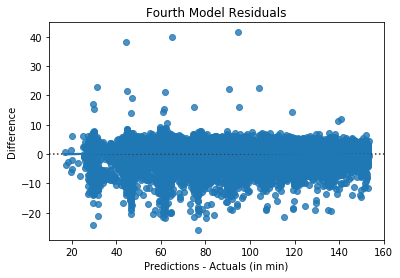

In [119]:
sns.residplot(y4_test,y4_pred,lowess=True)
plt.title('Fourth Model Residuals')
plt.xlabel('Predictions - Actuals (in min)')
plt.ylabel('Difference')
plt.show()

We're getting there! We don't want to include any features that aren't adding any value to our prediction model. In model 4, there are two more features that have high p-values. For our fifth model, we're going to remove Traffic_Calming and run again.

In [104]:
features_5 = USA_2019[['Severity','Start_Lat','Start_Lng', 'State', 'Temperature(F)','Humidity(%)', 'Pressure(in)', 
                     'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Crossing', 'No_Exit', 'Railway', 
                     'Traffic_Signal', 'Sunrise_Sunset']]

In [105]:
X5_train, X5_test, y5_train, y5_test = train_test_split(features_5, target, random_state=34,test_size=0.2)

In [106]:
model_5 = sm.OLS(y4_train, X5_train.astype(float)).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Time_Lapse   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          6.601e+04
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:27:39   Log-Likelihood:                     -7.6804e+05
No. Observations:              161017   AIC:                                  1.536e+06
Df Residuals:                  161002   BIC:                                  1.536e+06
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Severity             -1.4582      0.285     -5.123      0.000      -2.016      -0.900
Start_Lat             0.1980      0.016     12.506      0.000       0.167       0.229
Start_Lng            -0.0288      0.005     -5.595      0.000      -0.039      -0.019
State                 0.0320      0.005      5.866      0.000       0.021       0.043
Temperature(F)        0.1575      0.005     32.701      0.000       0.148       0.167
Humidity(%)           0.0172      0.004      4.268      0.000       0.009       0.025
Pressure(in)          1.6215      0.036     44.803      0.000       1.551       1.692
Visibility(mi)        0.5263      0.031     16.989      0.000       0.466       0.587
Wind_Speed(mph)      -0.0397      0.014     -2.787      0.005      -0.068      -0.012
Weather_Condition    -0.0211      0.004     -5.409      0.000      -0.029      -0.013
Crossing             -1.4985      0.243     -6.158      0.000      -1.975      -1.022
No_Exit              -4.6585      1.515     -3.076      0.002      -7.627      -1.690
Railway               2.2573      0.650      3.475      0.001       0.984       3.530
Traffic_Signal        1.0320      0.176      5.865      0.000       0.687       1.377
Sunrise_Sunset       -0.5871      0.186     -3.154      0.002      -0.952      -0.222
==============================================================================
Omnibus:                     9306.521   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11034.947
Skew:                           0.641   Prob(JB):                         0.00
Kurtosis:                       3.000   Cond. No.                     3.05e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [114]:
# 15 features are now being used to predict our delay time.

features_5.shape

(201272, 15)

In [131]:
y5_pred_train = model_5.predict(X5_train)
y5_pred_test = model_5.predict(X5_test)

In [116]:
residual = y5_pred - y5_test

In [138]:
print('Train - Mean Absolute Error:' + str(metrics.mean_absolute_error(y5_train, y5_pred_train)))
print('Train - Mean Squared Error:' + str(metrics.mean_squared_error(y5_train, y5_pred_train)))
print('Train - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y5_train, y5_pred_train))))

print("")

print('Test - Mean Absolute Error:' + str(metrics.mean_absolute_error(y5_test, y5_pred_test)))
print('Test - Mean Squared Error:' + str(metrics.mean_squared_error(y5_test, y5_pred_test)))
print('Test - SqRt Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y5_test, y5_pred_test))))

Train - Mean Absolute Error:22.7360261002642
Train - Mean Squared Error:813.9890678116138
Train - SqRt Mean Squared Error:28.530493648228624

Test - Mean Absolute Error:22.73191760230083
Test - Mean Squared Error:815.8573121754054
Test - SqRt Mean Squared Error:28.5632160684928


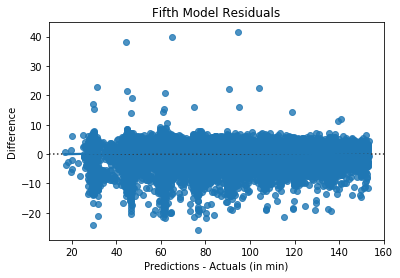

In [118]:
sns.residplot(y5_test,y5_pred,lowess=True)
plt.title('Fifth Model Residuals')
plt.xlabel('Predictions - Actuals (in min)')
plt.ylabel('Difference')
plt.show()

There we have it! We have a model that looks to 15 features to predict our delay time. We're removed any extraneous features that aren't adding any value and are getting an R-Squared value of 0.86. When we compare out RMSE, we remain the same from models 2 through 5 since we're only removing redundancies and features that are not statistically significant (meaning that their coefficient is equivalent to 0) from our model. Now it's time to predict how long you'll wait in traffic if you come across an accident!